In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tensorboard.backend.event_processing import event_accumulator

In [2]:
RESULTS_PATH = "../results/baselines"
LOGS_TEMPLATE_PATH = os.path.join(RESULTS_PATH, "%s", "tb", "SAC_1")

LOG_PATH_LIST = [LOGS_TEMPLATE_PATH % folder for folder in os.listdir(RESULTS_PATH) if os.path.isdir(os.path.join(RESULTS_PATH, folder))]
LOG_PATH_LIST = sorted([os.path.join(log_path, os.listdir(log_path)[0]) for log_path in LOG_PATH_LIST])

In [3]:
results_dict = defaultdict(dict)
all_experiment_combinations = set()

for filepath in LOG_PATH_LIST:
    run_name = filepath.split("/")[-4]
    baseline_type = run_name[:run_name.find("baseline")-1]
    environment = "_".join(run_name.split("_")[2:-3])
    # all_experiment_combinations.add("_".join(run_name.split("_")[2:-1]))
    
    ea = event_accumulator.EventAccumulator(filepath, size_guidance={"scalars": 0})
    ea.Reload()
    
    if environment not in results_dict[baseline_type]:
        results_dict[baseline_type][environment] = []
    # elif len(results_dict[baseline_type][environment][0]) != len(scalars):
    #     continue
    
    scalars = [scalar.value for scalar in ea.Scalars("eval/mean_reward")]
    # print(np.arange(100) * (len(scalars) / 100))
    # print(len(scalars))
    scalars = np.interp(np.arange(100) * (len(scalars) / 100), np.arange(len(scalars)), scalars).tolist()
    # print(len(scalars))
    results_dict[baseline_type][environment].append(scalars)
    # break
    
for baseline_type in results_dict.keys():
    for environment in results_dict[baseline_type].keys():
        results_dict[baseline_type][environment] = np.stack(results_dict[baseline_type][environment], axis=0)

In [4]:
def filter_recursively(keywords, dictionary):
    if len(keywords) == 0:
        assert not isinstance(dictionary, dict)
        return [""], [dictionary]
    
    experiment_key_list = []
    scalars_list = []
    for dict_key in dictionary.keys():
        if dict_key == keywords[0] or keywords[0] == "*":
            experiment_key, scalars = filter_recursively(keywords[1:], dictionary[dict_key])
            experiment_key = [dict_key + "-" + _experiment_key for _experiment_key in experiment_key]
            
            experiment_key_list += experiment_key
            scalars_list += scalars
            
    return experiment_key_list, scalars_list

In [5]:
results_dict.keys()

dict_keys(['regular', 'regular_better', 'sparse'])

done: 69.31%


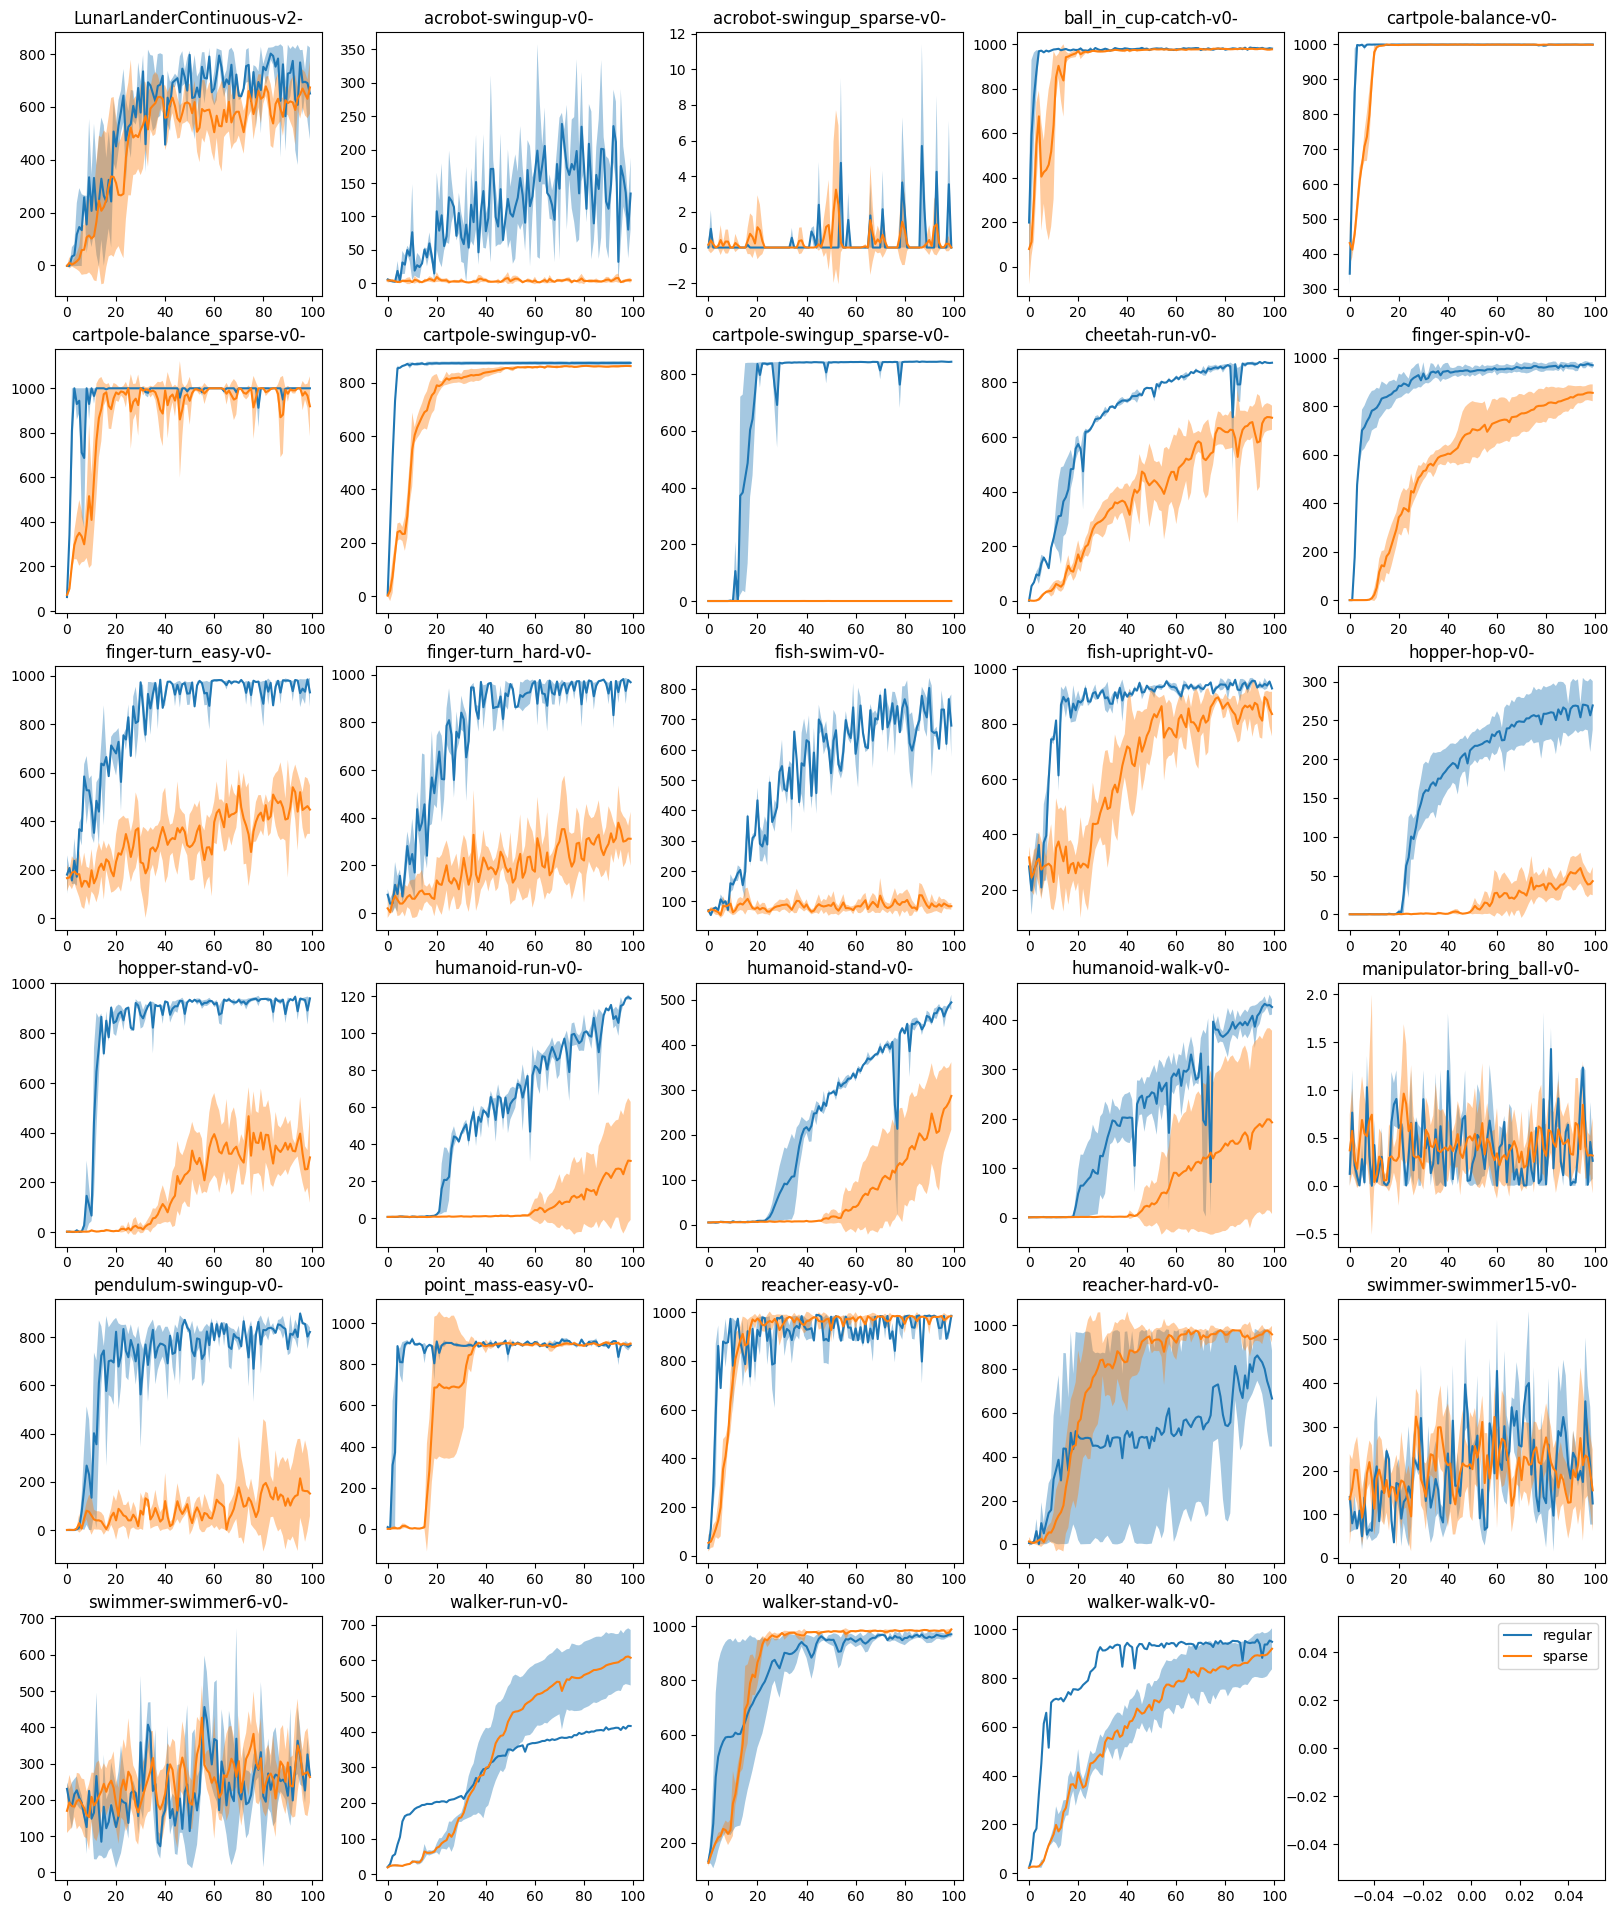

In [6]:
regular_keys_to_plot, regular_results_to_plot = filter_recursively("regular_better.*".split("."), results_dict)
regular_keys_to_plot = np.array(regular_keys_to_plot)[np.argsort(regular_keys_to_plot)]
regular_results_to_plot = np.array(regular_results_to_plot, dtype=object)[np.argsort(regular_keys_to_plot)]
# take care for lunarlander's varying reward scale.
regular_results_to_plot[0] /= 100

sparse_keys_to_plot, sparse_results_to_plot = filter_recursively("regular.*".split("."), results_dict)
sparse_keys_to_plot = np.array(sparse_keys_to_plot)[np.argsort(sparse_keys_to_plot)]
sparse_results_to_plot = np.array(sparse_results_to_plot, dtype=object)[np.argsort(sparse_keys_to_plot)]
# take care for lunarlander's varying reward scale.
sparse_results_to_plot[0] /= 100

nrows = int(np.ceil(len(regular_keys_to_plot) / 5))
fig, axes = plt.subplots(nrows, 5, figsize=(20, 4 * nrows))
axes = np.reshape(axes, -1)

labels = ["regular", "sparse"]

experiment_counter = 0
for idx, (keys_to_plot, results_to_plot) in enumerate(zip([regular_keys_to_plot, sparse_keys_to_plot], [regular_results_to_plot, sparse_results_to_plot])):
    for ax, key, result in zip(axes, keys_to_plot, results_to_plot):
        result = result.astype(float)
        experiment_counter += result.shape[0]
        
        ax.plot(result.mean(axis=0), c="C" + str(idx), label=labels[idx])
        if len(result) > 1:
            ax.fill_between(np.arange(len(result[0])), result.mean(axis=0) - result.std(axis=0), result.mean(axis=0) + result.std(axis=0), alpha=0.4)
        ax.set_title("-".join(key.split("-")[1:]))
    
    axes[-1].plot([0], [0], c="C" + str(idx), label=labels[idx])
    axes[-1].legend()

print("done: ", np.round(experiment_counter / (len(regular_keys_to_plot) * 5 * 2) * 100, 2), "%", sep="")